# SVM：支持向量机
- 与传统算法进行比较，看SVM究竟能带来什么样的效果
- 软间隔的作用，复杂的算法肯定会导致过拟合现象，如何来解决
- 核函数的作用

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### 支持向量机带来的效果

- 先将iris数据集变成一个二分类问题
- `y[y == 0] = 1 ; y[y != 0] = 0`会将y的所有值都转化为0
- `y = (y == 0).astype(int)`我的想法是：改成两类就行，可能结果不好弄

In [10]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, (2, 3)]
y = iris.target

# y = (y == 0).astype(int)

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

- 参数C：控制了误分类的惩罚力度。越大，对误分类容忍度越低；越小，对误分类容忍度越高
- `w = svc_clf.coef_`是二维数组，形状是(1, n_features)
- **决策边界**：x0w0 + x1w1 + b = 0
- 决策边界到支持向量的距离是 `margin = 1 / w[1]`；不应该是`margin = 1 / np.linalg.norm(w)`

In [14]:
svc_clf = SVC(kernel='linear', C=1e10)
svc_clf.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

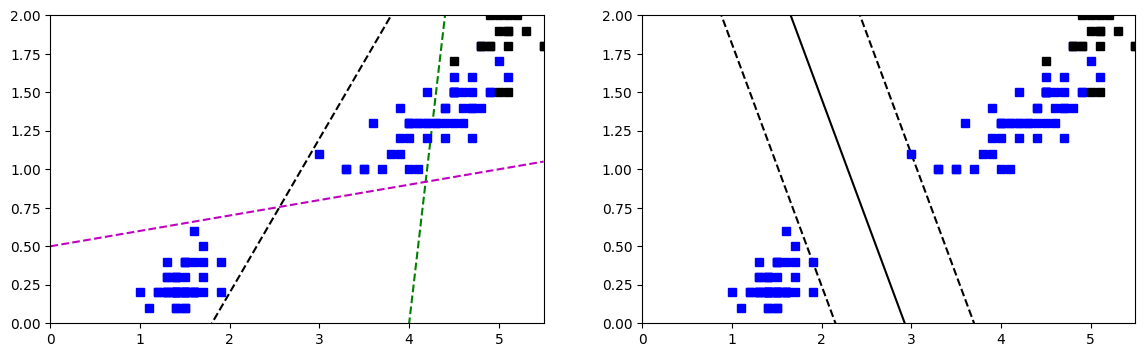

In [59]:
# 一般的模型
x0=np.linspace(0,5.5,200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svc_clf, xmin, xmax, sv=True):
    w = svc_clf.coef_[0]
    b = svc_clf.intercept_[0]
    x0=np.linspace(xmin, xmax, 200)
    decision_boundary = (-w[0] / w[1]) * x0 - b / w[1]
    margin = 1 / w[1]  # np.linalg.norm(w)
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    if sv:
        sv_ = svc_clf.support_vectors_
        plt.scatter(sv_[:, 0], sv_[:, 1], facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, 'k-')
    plt.plot(x0, gutter_up, 'k--')
    plt.plot(x0, gutter_down, 'k--')

plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(x0, pred_1, 'g--')
plt.plot(x0, pred_2, 'k--')
plt.plot(x0, pred_3, 'm--')
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bs')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'ks')
plt.axis([0, 5.5, 0, 2])
plt.subplot(122)
plot_svc_decision_boundary(svc_clf, 0, 5.5)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'bs')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'ks')
plt.axis([0, 5.5, 0, 2])

plt.show()

### 数据标准化的影响
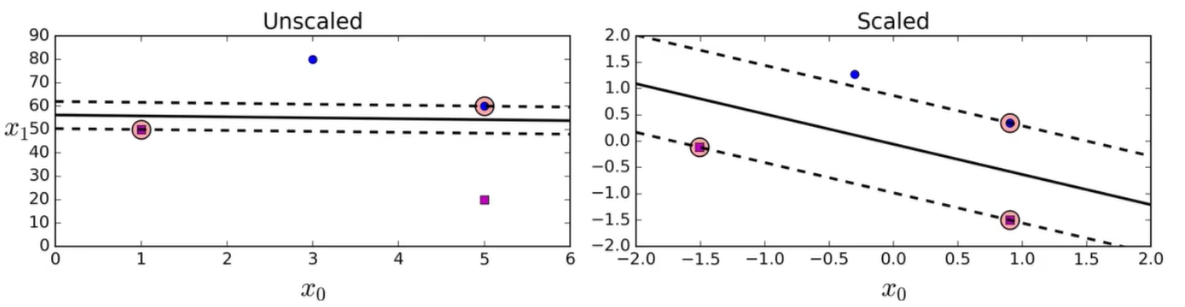

### 软间隔
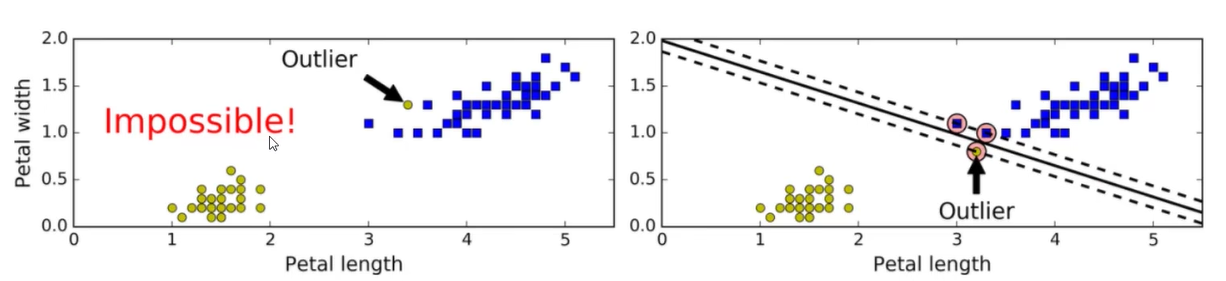
可以使用超参数C控制软间隔的程度

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 2).astype(int)

svm_clf = Pipeline((
    ('std', StandardScaler()), 
    ('svm', LinearSVC(C=1, dual=False)),
))
svm_clf.fit(X, y)

svm_clf.predict([[5.5, 1.7]])

array([1])

#### 不同的C值所带来的效果差异

In [61]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, dual=False, random_state=7)
svm_clf2 = LinearSVC(C=100, dual=False, random_state=7)

scaled_svm_clf_1 = Pipeline((
    ('std', scaler), 
    ('svm', svm_clf1),
))

scaled_svm_clf_2 = Pipeline((
    ('std', scaler), 
    ('svm', svm_clf2),
))

scaled_svm_clf_1.fit(X, y)
scaled_svm_clf_2.fit(X, y)

Pipeline(steps=[('std', StandardScaler()),
                ('svm', LinearSVC(C=100, dual=False, random_state=7))])

- 用模型得到的参数和截距都是数据经过标准化后得到的，需要对系数进行**反标准化**，将模型适配到未经过标准化的原始数据空间中
- 原始数据的均值对应于标准化空间中的零点——故输入标准化数据的中心点，决策函数decision_function的输出就是模型的截距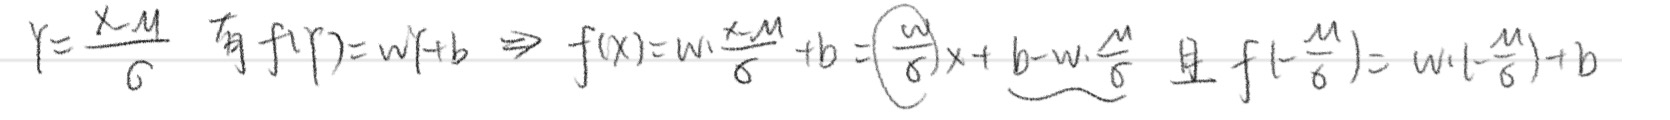

In [62]:
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

(4.0, 6.0, 0.8, 2.8)

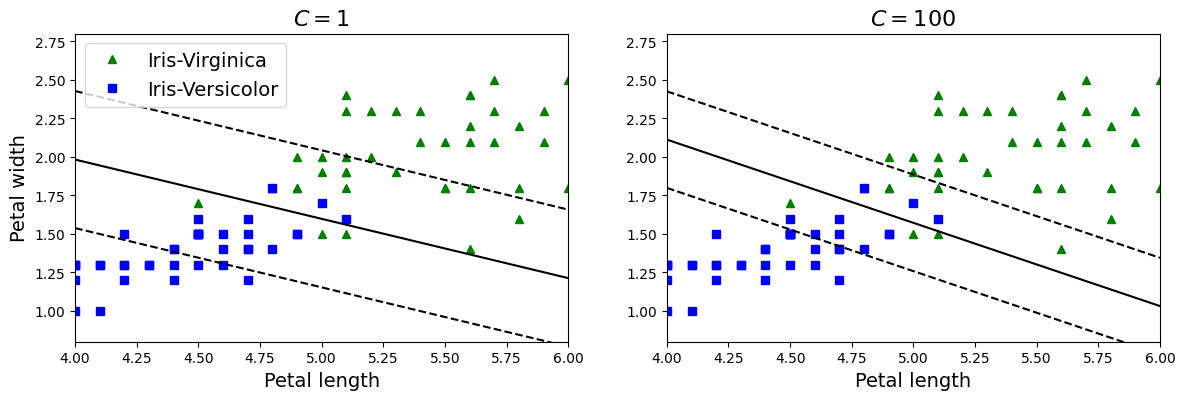

In [64]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6, sv=False)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title(r"$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6, sv=False)
plt.xlabel("Petal length", fontsize=14)
plt.title(r"$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

- 在左侧，使用较低的C值，间隔要大得多，但是很多实例最终会出现在间隔之内
- 在右侧，使用较高的C值，分类器会减少误分类，但最终会有较小间隔

### 非线性支持向量机

#### 自己构建

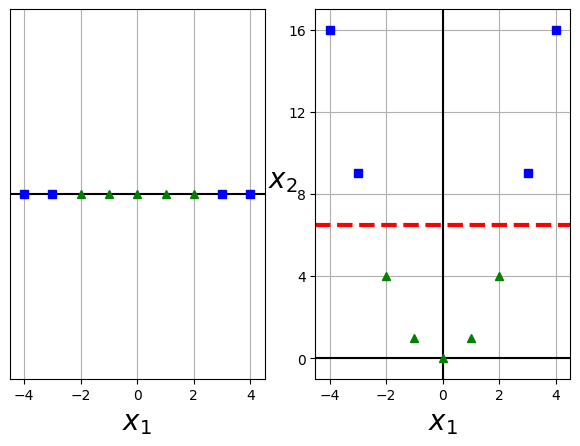

In [66]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D ** 2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)
plt.show()

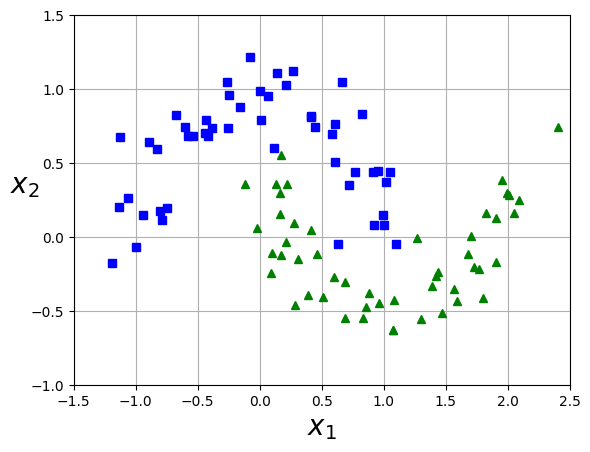

In [93]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=7)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [77]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline(
    (
        ('poly_featrues', PolynomialFeatures(degree=3)),
        ('scaler', StandardScaler()),
        ('svm_clf', LinearSVC(C=10, loss='hinge', dual='auto')),
    )
)

polynomial_svm_clf.fit(X, y)

D:\envs\fxr_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_featrues', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, dual='auto', loss='hinge'))])

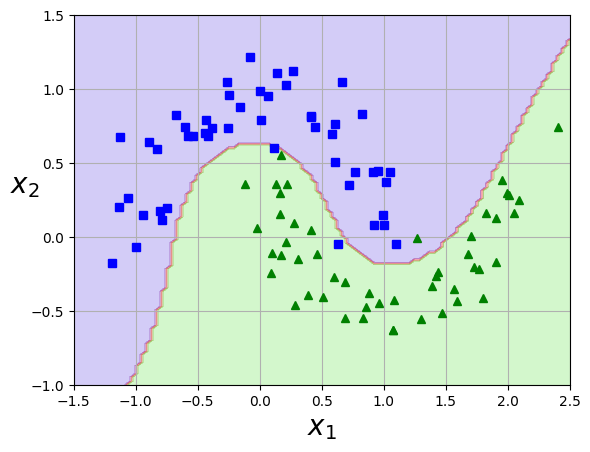

In [78]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

### 核函数——SVM中的核技巧

比较degree值的影响

In [80]:
from sklearn.svm import SVC

poly_kernel_svm_clf_1 = Pipeline(
    (
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5)
    )
))
poly_kernel_svm_clf_1.fit(X, y)

poly_kernel_svm_clf_2 = Pipeline(
    (
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5)
    )
))
poly_kernel_svm_clf_2.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

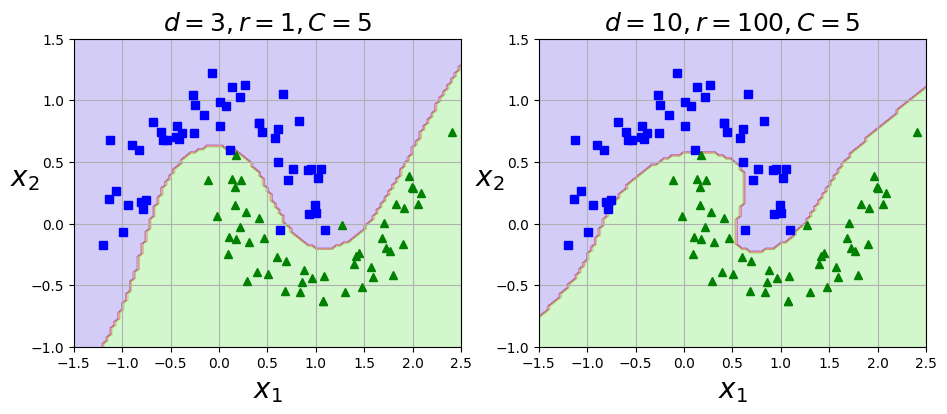

In [82]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf_1, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly_kernel_svm_clf_2, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

plt.show()

### **高斯核函数** 最常用
- 利用**相似度**来变换特征

- 选择一份一维数据集，并在x=-2和x=1处为其添加两个高斯函数
- 将相似度函数定义为γ=0.3的径向基函数（RBF）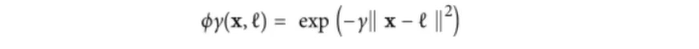
- 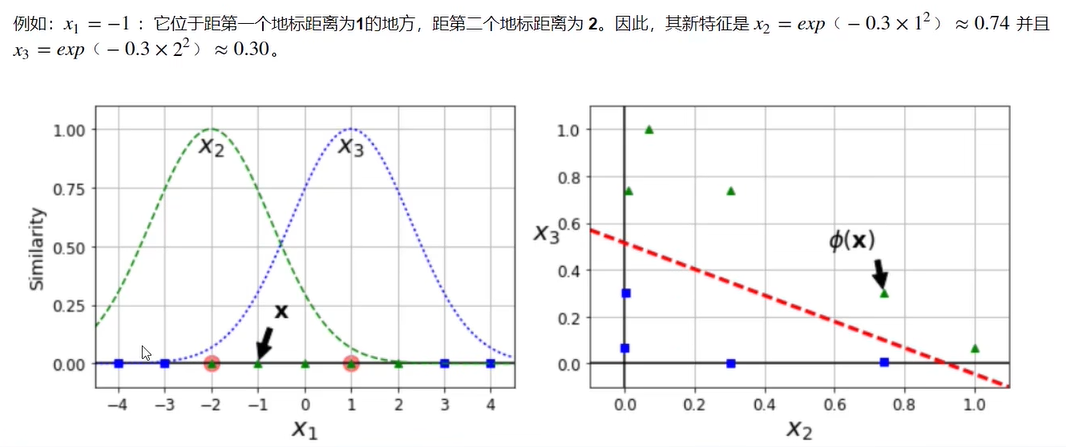

自己改变gamma值
- 越小，考虑越全面，过拟合风险越低
- 越大， 过拟合风险越大

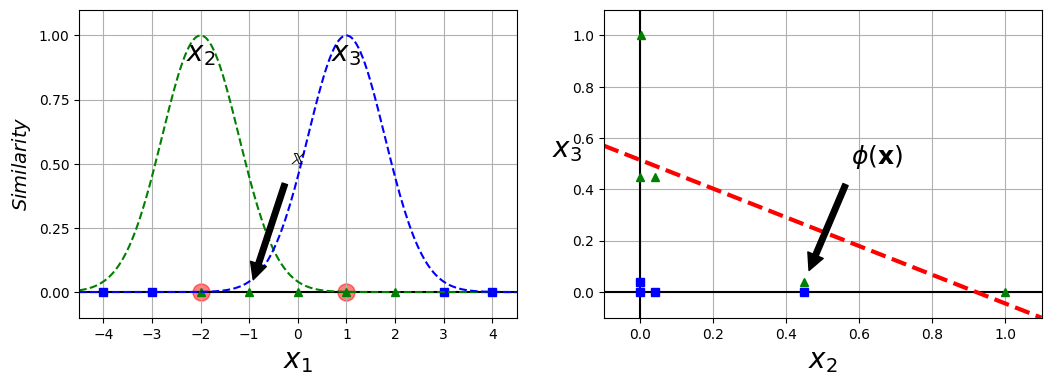

In [90]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1) ** 2)

gamma = 0.8

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D ** 2]

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
# 两个点
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c='red')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
# 高斯图
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b--")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$Similarity$", fontsize=14)
plt.annotate(r"$\mathbb{x}$",
             xy=(X1D[3], 0),  # 标注位置
             xytext=(0, 0.5),  # 标注文本位置
             ha='center',
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18)

plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][y==0], XK[:, 1][y==0], "bs")
plt.plot(XK[:, 0][y==1], XK[:, 1][y==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$", fontsize=20, rotation=0)
plt.annotate(r"$\phi\left(\mathbf{x}\right)$",
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha='center',
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18)
# 画边界，自己画的
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])

plt.subplots_adjust(right=1)
plt.show()

#### SVM中利用了核函数的计算技巧，大大降低了计算复杂度
- 增加gamma使得高斯曲线变窄，因此每个实例的影响范围都较小；决策边界最终变的更不规则，在个别实例周围摆动
- 减小gamma使高斯曲线变宽，实例具有更大的影响范围，并且决策边界更加平滑

In [95]:
rbf_kernel_svm_clf = Pipeline(
    (
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
    )
)
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

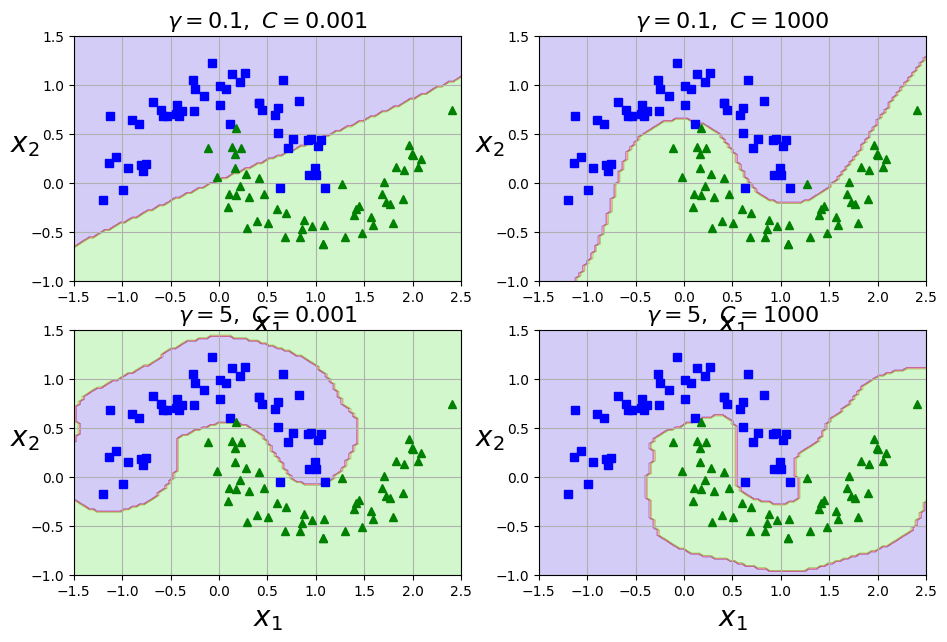

In [96]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = [(gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)]

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
    ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, \ C = {}$".format(gamma, C), fontsize=16)

plt.show()